# Bangla Cyberbullying Classification with LSTM

This notebook implements an LSTM neural network for multi-class classification of Bangla cyberbullying text.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
from sklearn.preprocessing import label_binarize, LabelEncoder
from bnlp import SentencepieceTokenizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import time
from itertools import cycle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings

warnings.filterwarnings("ignore")

# Set plot style
plt.style.use("ggplot")
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 1. Loading and Exploring Datasets

In [3]:
# 1. Load the datasets
print("Loading datasets...")
original_cleaned_df = pd.read_csv("../../dataset/cleaned/original_cleaned.csv")
only_augmented_cleaned_df = pd.read_csv("../../dataset/cleaned/only_augmented.csv")

print(f"Original dataset shape: {original_cleaned_df.shape}")
print(f"Augmented dataset shape: {only_augmented_cleaned_df.shape}")

Loading datasets...
Original dataset shape: (41907, 6)
Augmented dataset shape: (6081, 3)


In [4]:
# Display the first few rows of original dataset
original_cleaned_df.head()

,comment,Category,Gender,comment react number,label,text_length
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,Actor,Female,1.0,sexual,128
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,Singer,Male,2.0,not bully,30
2,অরে বাবা টা পাগল,Actor,Female,2.0,not bully,16
3,ক্যাপ্টেন অফ বাংলাদেশ,Sports,Male,0.0,not bully,21
4,পটকা মাছ,Politician,Male,0.0,troll,8


## 2. Label Mapping and Visualization

In [5]:
# Map the labels for both datasets
label_mapping = {"not bully": 0, "troll": 1, "sexual": 2, "religious": 3, "threat": 4}

original_cleaned_df["label_encoded"] = original_cleaned_df["label"].map(label_mapping)
only_augmented_cleaned_df["label_encoded"] = only_augmented_cleaned_df["label"].map(
    label_mapping
)

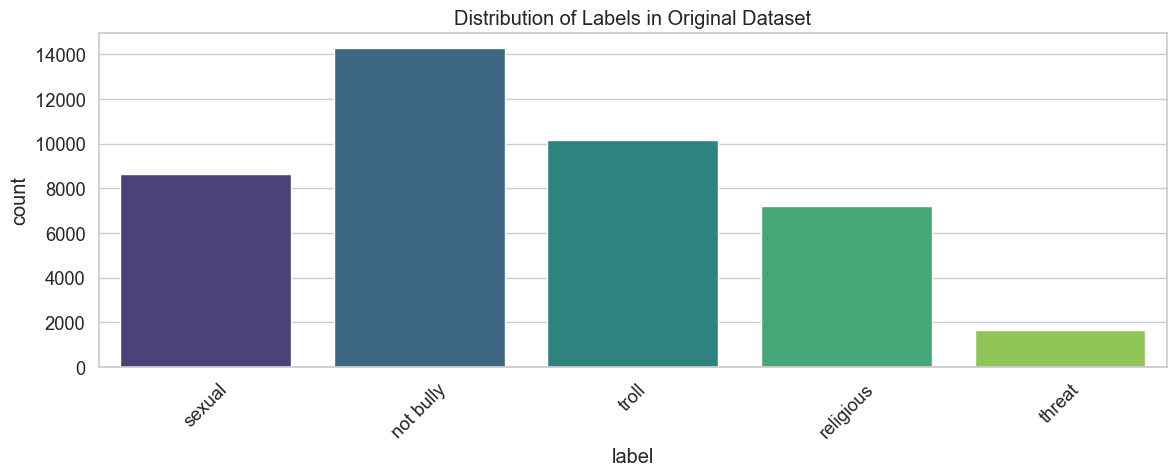

In [6]:
# Check the distribution of labels
plt.figure(figsize=(12, 5))
sns.countplot(x="label", data=original_cleaned_df, palette="viridis")
plt.title("Distribution of Labels in Original Dataset")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Splitting and Augmentation

In [7]:
# Split the original dataset into train and test sets
X = original_cleaned_df["comment"]
y = original_cleaned_df["label_encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size before augmentation: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size before augmentation: 33525
Test set size: 8382


In [8]:
# Add augmented data to the training set
X_aug = only_augmented_cleaned_df["text"]
y_aug = only_augmented_cleaned_df["label_encoded"]

# Concatenate original training data with augmented data
X_train_augmented = pd.concat([X_train, X_aug])
y_train_augmented = pd.concat([y_train, y_aug])

print(f"Training set size after augmentation: {len(X_train_augmented)}")

Training set size after augmentation: 39606


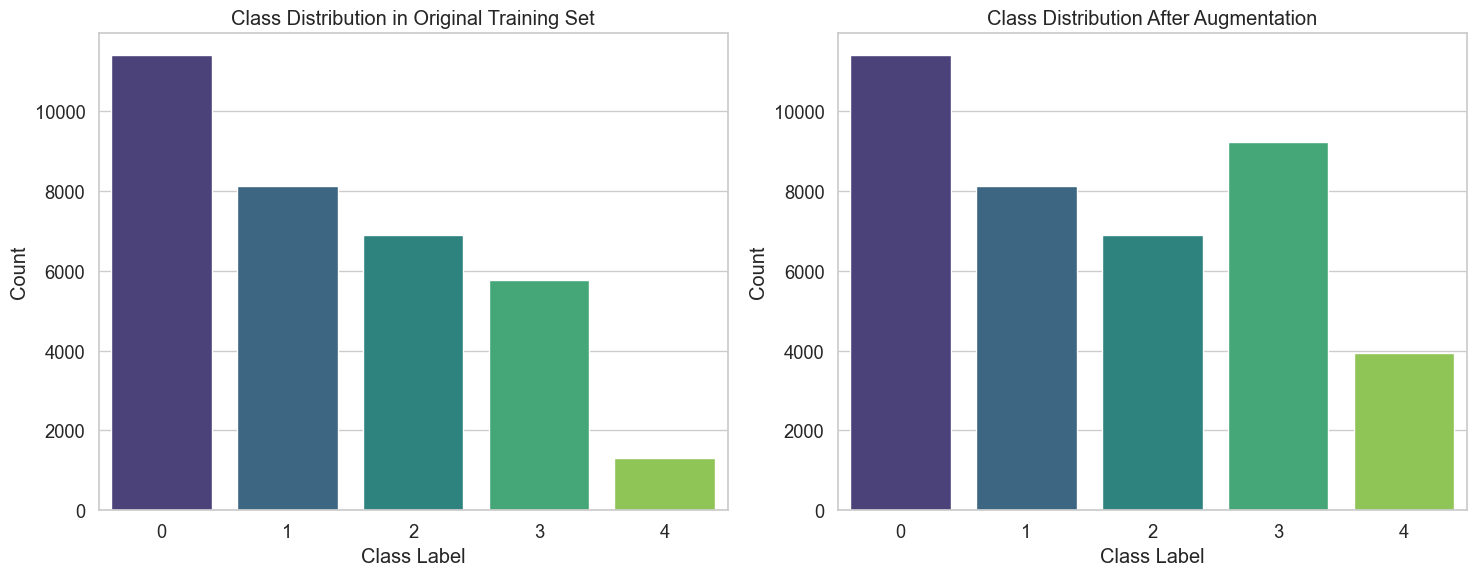

In [9]:
# Visualize the class distribution before and after augmentation
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train, palette="viridis")
plt.title("Class Distribution in Original Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_train_augmented, palette="viridis")
plt.title("Class Distribution After Augmentation")
plt.xlabel("Class Label")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

## 4. Text Tokenization and Sequence Preparation for LSTM

In [10]:
# Initialize SentencepieceTokenizer for tokenization
print("Initializing tokenizer...")
sp_tokenizer = SentencepieceTokenizer()

Initializing tokenizer...


In [11]:
def tokenize_text(texts, max_len=100):
    """Tokenize a list of texts and return sequences of token IDs"""
    sequences = []
    for text in texts:
        tokens = sp_tokenizer.tokenize(text)
        # Convert tokens to integers (we'll use index+1 to reserve 0 for padding)
        token_ids = [hash(token) % 20000 + 1 for token in tokens if token.strip()]
        sequences.append(token_ids)

    # Pad sequences to the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding="post")
    return padded_sequences

In [12]:
# Preprocess the training and testing data
print("Preprocessing training data...")
start_time = time.time()
MAX_SEQUENCE_LENGTH = 100  # Maximum length of sequences
VOCAB_SIZE = 20000  # Size of vocabulary (number of unique tokens)

# Convert text to sequences of token IDs
X_train_sequences = tokenize_text(X_train_augmented, MAX_SEQUENCE_LENGTH)
print(f"Training data preprocessing completed in {time.time() - start_time:.2f} seconds")
print(f"Training sequence shape: {X_train_sequences.shape}")

Preprocessing training data...
Training data preprocessing completed in 0.98 seconds
Training sequence shape: (39606, 100)


In [13]:
# Preprocess test data
print("Preprocessing testing data...")
start_time = time.time()
X_test_sequences = tokenize_text(X_test, MAX_SEQUENCE_LENGTH)
print(f"Testing data preprocessing completed in {time.time() - start_time:.2f} seconds")
print(f"Testing sequence shape: {X_test_sequences.shape}")

# Convert labels to categorical format for neural network
num_classes = 5  # Based on the label mapping
y_train_cat = to_categorical(y_train_augmented, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

Preprocessing testing data...
Testing data preprocessing completed in 0.23 seconds
Testing sequence shape: (8382, 100)


## 5. Building and Training LSTM Model

In [14]:
# Configure and build LSTM model
print("Building LSTM model...")

# Define model parameters
EMBEDDING_DIM = 128
LSTM_UNITS = 64
DROPOUT_RATE = 0.3

# Build the model
model = Sequential([
    # Embedding layer - maps token IDs to dense vectors
    Embedding(input_dim=VOCAB_SIZE+1, output_dim=EMBEDDING_DIM,
               input_length=MAX_SEQUENCE_LENGTH, mask_zero=True),
    
    # Bidirectional LSTM layer
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=True)),
    Dropout(DROPOUT_RATE),
    
    # Second LSTM layer
    Bidirectional(LSTM(LSTM_UNITS)),
    Dropout(DROPOUT_RATE),
    
    # Output layer with softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Building LSTM model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Set up callbacks for early stopping and model checkpointing
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath='../../models/lstm/best_model.h5',
    monitor='val_loss',
    save_best_only=True
)

# Train the model
print("Training LSTM model...")
start_time = time.time()

history = model.fit(
    X_train_sequences,
    y_train_cat,
    validation_split=0.1,  # 10% of training data for validation
    epochs=10,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

training_time = time.time() - start_time
print(f"Model trained in {training_time:.2f} seconds")

Training LSTM model...
Epoch 1/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6558 - loss: 0.9283

1114/1114 ━━━━━━━━━━━━━━━━━━━━ 86s 72ms/step - accuracy: 0.6559 - loss: 0.9281 - val_accuracy: 0.7422 - val_loss: 0.8374
Epoch 2/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8311 - loss: 0.4992

1114/1114 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.8311 - loss: 0.4992 - val_accuracy: 0.7728 - val_loss: 0.7676
Epoch 3/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 92s 83ms/step - accuracy: 0.8707 - loss: 0.3996 - val_accuracy: 0.8008 - val_loss: 0.7737
Epoch 4/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8976 - loss: 0.3218

1114/1114 ━━━━━━━━━━━━━━━━━━━━ 84s 76ms/step - accuracy: 0.8976 - loss: 0.3218 - val_accuracy: 0.8324 - val_loss: 0.7251
Epoch 5/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 106s 95ms/step - accuracy: 0.9196 - loss: 0.2598 - val_accuracy: 0.8301 - val_loss: 0.7688
Epoch 6/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 108s 97ms/step - accuracy: 0.9363 - loss: 0.2067 - val_accuracy: 0.8228 - val_loss: 0.8604
Epoch 7/10
1114/1114 ━━━━━━━━━━━━━━━━━━━━ 99s 89ms/step - accuracy: 0.9430 - loss: 0.1778 - val_accuracy: 0.8266 - val_loss: 0.9204
Model trained in 660.77 seconds


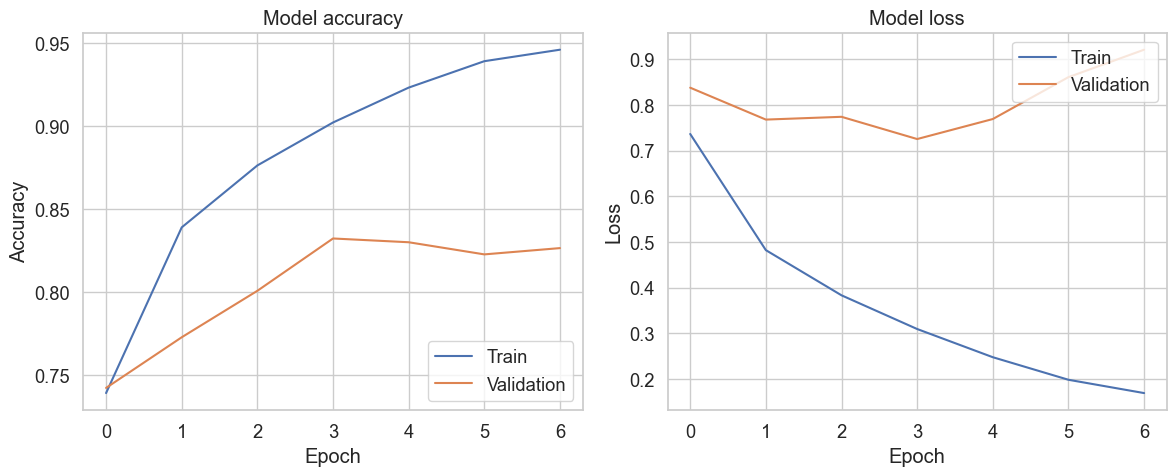

In [16]:
# Plot training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

## 6. Model Evaluation - Basic Metrics

In [17]:
# Evaluate the model on test data
print("Evaluating model...")
test_loss, test_acc = model.evaluate(X_test_sequences, y_test_cat, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Make predictions
y_pred_proba = model.predict(X_test_sequences)
y_pred_classes = np.argmax(y_pred_proba, axis=1)
y_test_classes = np.argmax(y_test_cat, axis=1)

# Calculate basic metrics
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1 = f1_score(y_test_classes, y_pred_classes, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Evaluating model...
Test accuracy: 0.7886
Test loss: 0.7224
262/262 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Accuracy: 0.7886
Precision: 0.7888
Recall: 0.7886
F1 Score: 0.7886


In [18]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=list(label_mapping.keys())))

Classification Report:
              precision    recall  f1-score   support

   not bully       0.80      0.82      0.81      2852
       troll       0.72      0.70      0.71      2031
      sexual       0.80      0.79      0.79      1726
   religious       0.88      0.87      0.87      1443
      threat       0.66      0.72      0.69       330

    accuracy                           0.79      8382
   macro avg       0.77      0.78      0.78      8382
weighted avg       0.79      0.79      0.79      8382



## 7. Confusion Matrix Visualization

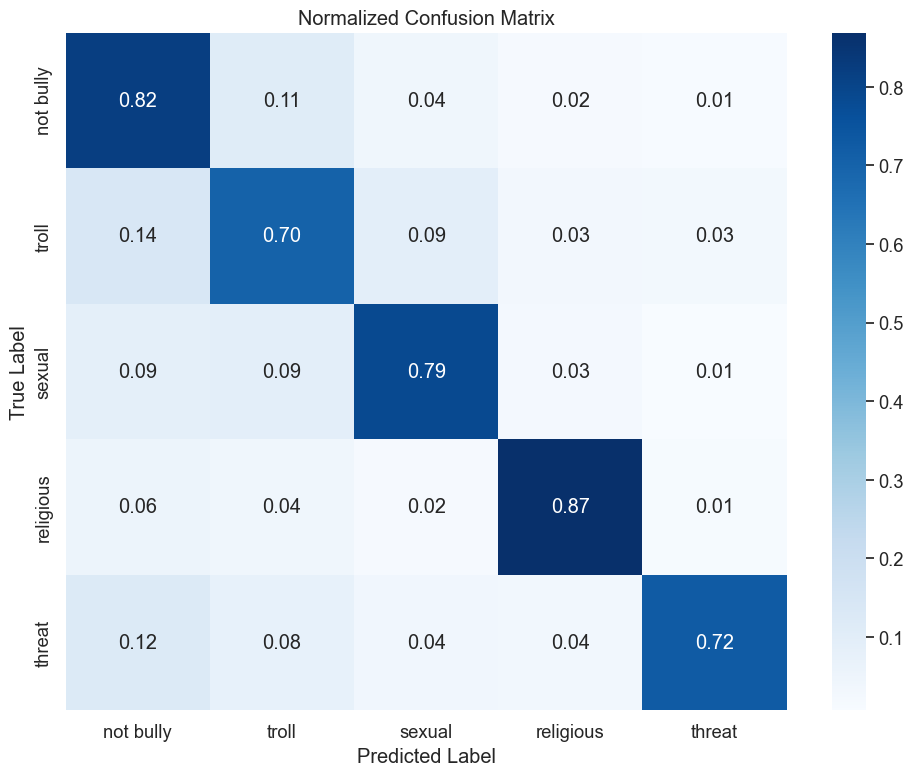

In [19]:
# Create and display confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred_classes)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # Normalize
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()

## 8. Attention Visualization for LSTM

In [20]:
# Since we don't have an attention layer in our current model,
# we can instead analyze the class activation by looking at some examples
def predict_and_explain(text, actual_label=None):
    # Tokenize and convert to sequence
    sequence = tokenize_text([text], MAX_SEQUENCE_LENGTH)
    # Get prediction
    prediction = model.predict(sequence)[0]
    predicted_class = np.argmax(prediction)
    
    # Print results
    print(f"Text: {text}")
    if actual_label is not None:
        print(f"Actual class: {list(label_mapping.keys())[actual_label]}")
    print(f"Predicted class: {list(label_mapping.keys())[predicted_class]}")
    print("Class probabilities:")
    for i, class_name in enumerate(label_mapping.keys()):
        print(f"  {class_name}: {prediction[i]:.4f}")
    print("\n")
    
    return predicted_class, prediction

# Let's examine some examples from the test set
sample_indices = np.random.choice(range(len(X_test)), 5, replace=False)
for idx in sample_indices:
    text = X_test.iloc[idx]
    label = y_test.iloc[idx]
    predict_and_explain(text, label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Text: তোই ছিলে হ্যাঁ দেখি তোই একটা মুখোসদাড়ি নাস্তিক তোরে বাঁশ ইচ্ছা করতাছে
Actual class: religious
Predicted class: religious
Class probabilities:
  not bully: 0.0073
  troll: 0.0459
  sexual: 0.0026
  religious: 0.8317
  threat: 0.1125


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Text: অবশেষে নারী বাদি মাগুদের কাতারে নাম লিখালে পাবলিক পিগারে আগুন ধরাইচত রে দেখ পাপলিক কিভাবে বাশ দেয়
Actual class: not bully
Predicted class: troll
Class probabilities:
  not bully: 0.0881
  troll: 0.8409
  sexual: 0.0421
  religious: 0.0020
  threat: 0.0270


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Text: চুদিয়া দিমু
Actual class: sexual
Predicted class: sexual
Class probabilities:
  not bully: 0.0029
  troll: 0.0466
  sexual: 0.9398
  religious: 0.0032
  threat: 0.0075


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Text: অরেহ বাটপার
Actual class: troll
Predicted class: troll
Class probabilities:
  not bully: 0.0980
  troll: 0.8851
  sexual: 0.0135
  religious: 0.0006
  threat: 0.0

## 9. ROC Curve Analysis

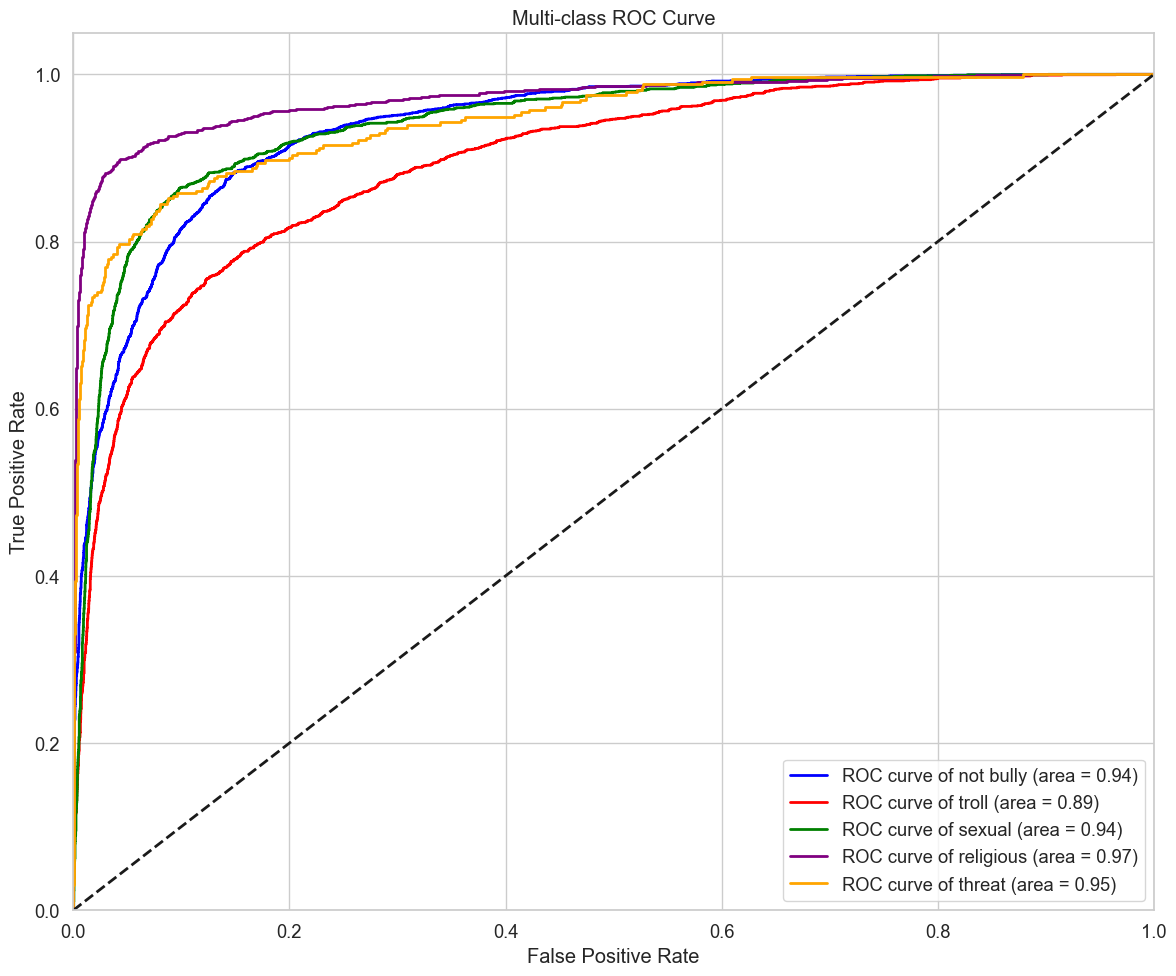

In [21]:
# ROC Curve and AUC for each class
# We already have y_test_cat and y_pred_proba

# Calculate ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 10))
colors = cycle(["blue", "red", "green", "purple", "orange"])
class_names = list(label_mapping.keys())

for i, color, class_name in zip(range(5), colors, class_names):
    fpr[i], tpr[i], _ = roc_curve(y_test_cat[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"ROC curve of {class_name} (area = {roc_auc[i]:.2f})",
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## 10. Precision-Recall Curve Analysis

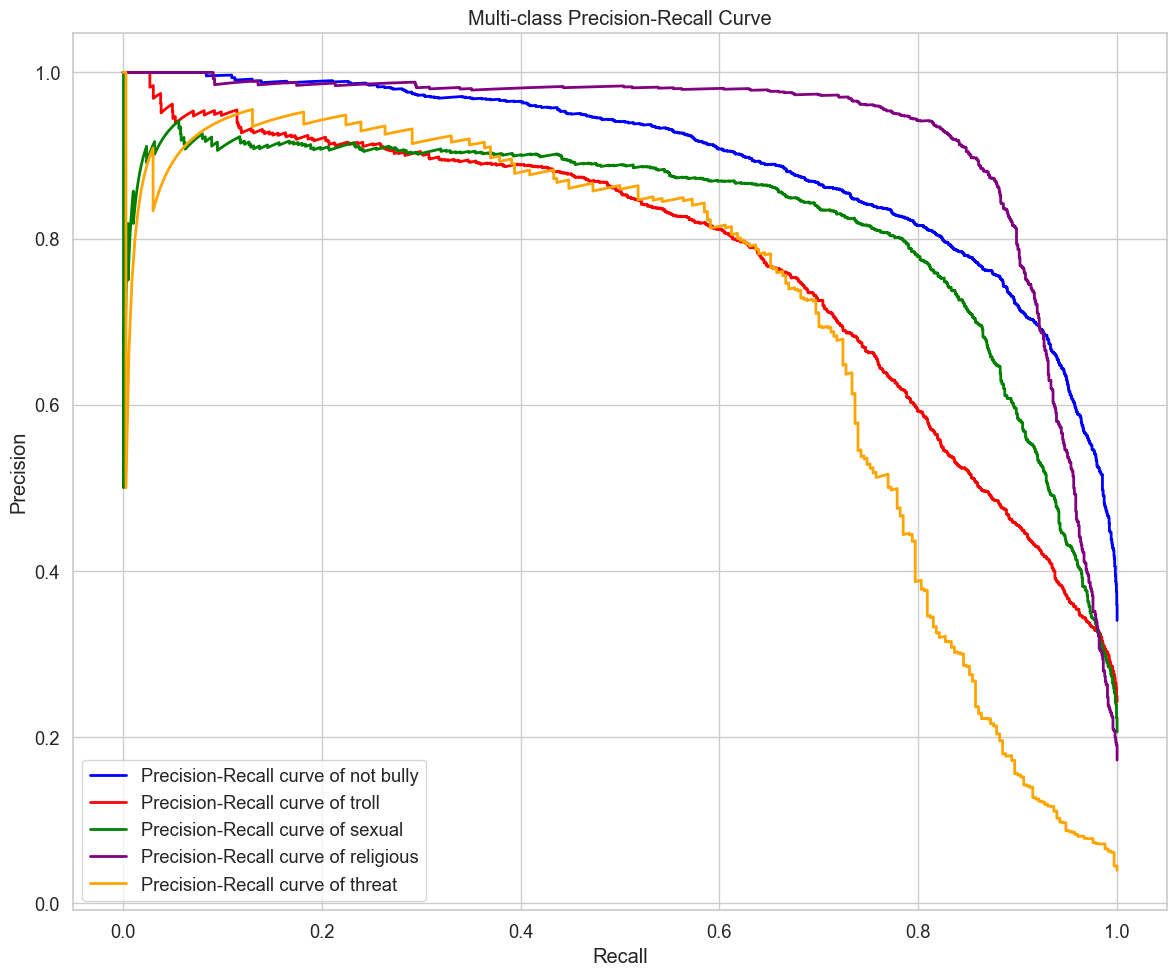

In [22]:
# Calculate Precision-Recall curve for each class
precision = {}
recall = {}
plt.figure(figsize=(12, 10))

for i, color, class_name in zip(range(5), colors, class_names):
    precision[i], recall[i], _ = precision_recall_curve(y_test_cat[:, i], y_pred_proba[:, i])
    plt.plot(
        recall[i],
        precision[i],
        color=color,
        lw=2,
        label=f"Precision-Recall curve of {class_name}",
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Multi-class Precision-Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

## 11. Model Summary and Saving

In [23]:
# Summary of the model
print("Model Summary:")
print(f"Total samples in training set (with augmentation): {len(X_train_augmented)}")
print(f"Total samples in test set: {len(X_test)}")
print(f"Sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Final model accuracy on test set: {accuracy:.4f}")
print(f"Training time: {training_time:.2f} seconds")

Model Summary:
Total samples in training set (with augmentation): 39606
Total samples in test set: 8382
Sequence length: 100
Vocabulary size: 20000
Final model accuracy on test set: 0.7886
Training time: 660.77 seconds


In [24]:
# Save the model
model.save("../../models/lstm/multiclass_lstm_model.h5")
print("Model saved successfully!")

Model saved successfully!
